## Load model and predict

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
from PIL import Image
import numpy as np
import os
from numpy import asarray

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Import Unet Loss

In [4]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
#     "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()
    

In [5]:
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
#     "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(dim=1).float()
    union = (input+targs).sum(dim=1).float()
    if not iou: l = 2. * intersect / union
    else: l = intersect / (union-intersect+eps)
    l[union == 0.] = 1.
    return l.mean()

In [6]:
import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

In [7]:
def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

In [8]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

### Load Model

In [9]:
save_model_path = "/home/jovyan/work/workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Model_export"

In [10]:
learn = load_learner(save_model_path)

In [11]:
import cv2
from PIL import Image
import numpy as np
import os
from numpy import asarray

path = "workspace/Xikun_Reps/FOSS4G/Unet_burnt_area/Data/Train_300/Images_300_allMixed/IMG-342.png"
img_test = "/home/jovyan/work/" + path
img = Image.open(img_test)

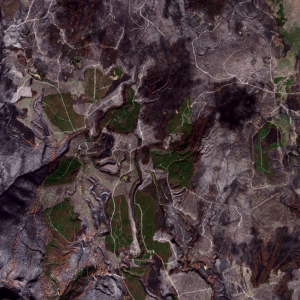

In [12]:
img

In [13]:
## resize the input image and after prediction, return to original dimensions
def resize_shape(image):
    width, height = image.size
    image.thumbnail((300,300))
    image = asarray(image)
    hg = image.shape[0]
    wd = image.shape[1]
    fixed_array = np.zeros([300,300, 3], dtype=np.uint8)
    fixed_array[0:hg, 0:wd] = image
    fixed_image = Image.fromarray(fixed_array)
    fixed_image.save(save_model_path + "temp.png")
    fixed_image = open_image(save_model_path + "temp.png") 
    return fixed_image, hg, wd, height, width


def return_ori(image, hg, wd, height, width):
    image_part = image[0:hg, 0:wd]
    
    image_part = Image.fromarray(image_part.astype('uint8'))
    image_part = image_part.resize((width, height))
    image_ori = asarray(image_part, dtype = "int64")
    return image_ori

In [14]:
resize_img, hg, wd, height, width = resize_shape(img)

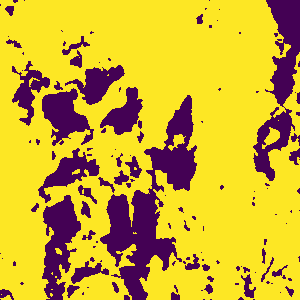

In [15]:
img_pre = learn.predict(resize_img)
img_pre[0]

In [17]:
img_pre = img_pre[1][0].numpy()

In [18]:
image_ori = return_ori(img_pre, hg, wd, height, width)

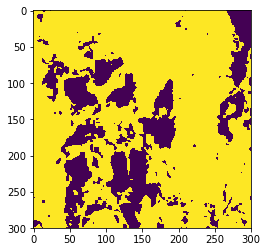

In [19]:
plt.imshow(image_ori)